In [1]:
%matplotlib inline
import sys
sys.path.append("..") # Adds the module to path

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import deeptrack as dt

In [48]:

argspec = inspect.getfullargspec(iaa.AverageBlur)
argspec

FullArgSpec(args=['self', 'k', 'seed', 'name', 'random_state', 'deterministic'], varargs=None, varkw=None, defaults=((1, 7), None, None, 'deprecated', 'deprecated'), kwonlyargs=[], kwonlydefaults=None, annotations={})

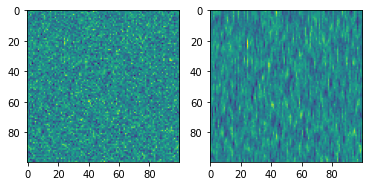

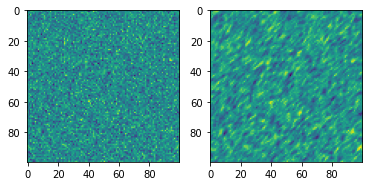

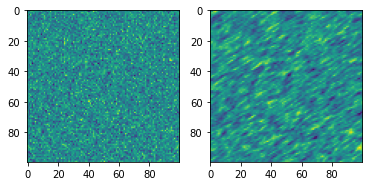

In [17]:

input = np.random.randn(100, 100, 1)
mb = dt.MotionBlur(angle=iter([0, 45, 60]), direction=1)

for _ in range(3):
    output= mb.update().resolve(input)

    plt.subplot(1, 2, 1)
    plt.imshow(input[..., 0])
    plt.subplot(1, 2, 2)
    plt.imshow(output[..., 0])
    
    plt.show()

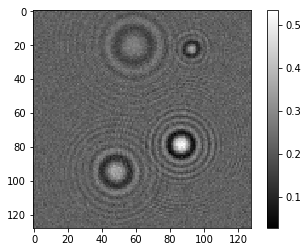

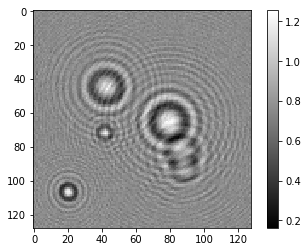

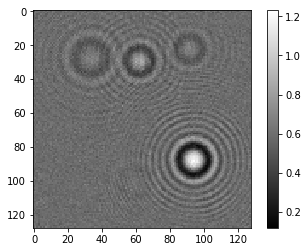

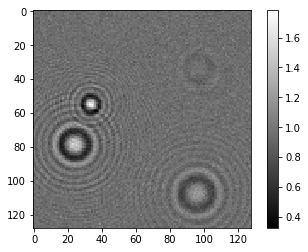

In [31]:
IMAGE_SIZE = 128
MIN_Z = 2e-6
MAX_Z = 30e-6
Z_SCALE = 5e-7
PIXEL_SCALE = 3.45e-7

optics = dt.Brightfield(
    NA=1.3,
    wavelength=633e-9,
    magnification=1,
    resolution=lambda magnification: (PIXEL_SCALE * magnification,) * 2 + (Z_SCALE * magnification,),
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    upscale=1,
    pupil=None
)

dt.HorizontalComa(coefficient=lambda: -3 - 2*np.random.rand()) + dt.VerticalComa(coefficient=lambda:  -3 - 2*np.random.rand())
particles = dt.MieParticle(
    position=lambda: 20 + np.random.rand(2) * (IMAGE_SIZE - 40),
    z=lambda: + MIN_Z / Z_SCALE + (np.random.rand() * (MAX_Z / Z_SCALE - MIN_Z / Z_SCALE)),
    position_unit="pixel",
    refractive_index=lambda: 1.4 + np.random.rand() * 0.3,
    radius=lambda: 100e-9 + np.random.rand() * 200e-9,
)

number_of_particles = lambda: 6

normalization = dt.NormalizeMinMax(min=lambda:np.random.rand()*0.5, max=lambda min: min + 0.5 + np.random.rand())

dataset = optics(particles ** number_of_particles) + dt.Poisson(snr=lambda: 20, background=1) + normalization
import deeptrack

for _ in range(4):
    image = dataset.update().resolve()
    plt.imshow(image[:, :, 0], cmap="gray")
    plt.colorbar()
    plt.show()

In [32]:
number_of_features = int(MAX_Z / Z_SCALE -  MIN_Z / Z_SCALE)

def get_label(image):
    output_1 = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 1))
    output_2 = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 1))
    
    X, Y = np.meshgrid(np.arange(0, IMAGE_SIZE),
                          np.arange(0, IMAGE_SIZE))
    
    positions = image.get_property("position", get_one=False)
    z_positions = image.get_property("z", get_one=False)
    
    for position, z in zip(positions, z_positions):

        mask = ((X - position[1]) ** 2 + 
                (Y - position[0]) ** 2) < 25
        output_1[mask] = 1
        output_2[mask] = -z * Z_SCALE / MAX_Z

    return [output_2, output_1]

52.590290882979126


TypeError: list indices must be integers or slices, not tuple

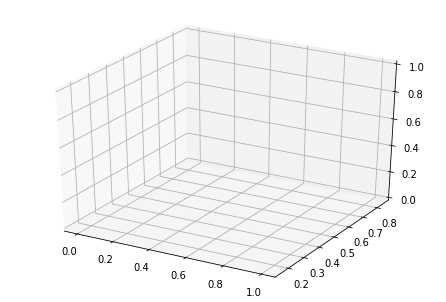

In [33]:
from mpl_toolkits.mplot3d import axes3d, Axes3D 

for _ in range(4):
    image = dataset.update().resolve()
    ground_truth = get_label(image)
    print(1/np.mean(ground_truth))
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.axis('equal')
    ax.voxels(ground_truth[::4, ::4, ::4])
    
    plt.show()
#     for z in range(100):
#         plt.imshow(ground_truth[:, z, :])
#         plt.show()

In [12]:
import keras.layers as layers
import keras.models as models

def branched_unet(input_shape=(None, None, 1),
                conv_layers_dimensions=(16, 32, 64, 128),
                base_conv_layers_dimensions=(128, 128),
                output_conv_layers_dimensions=(16, 16),
                dropout=(),
                steps_per_pooling=1,
                number_of_outputs=1,
                output_activation=None,
                layer_function=None, **kwargs):
    
    if layer_function is None:
        layer_function = lambda dimensions: layers.Conv2D(
            conv_layer_dimension,
            kernel_size=3,
            activation="relu",
            padding="same"
        )
    
    unet_input = layers.Input(input_shape)

    concat_layers = []

    layer = unet_input

    # Downsampling step
    for conv_layer_dimension in conv_layers_dimensions:
        for _ in range(steps_per_pooling):
            layer = layer_function(conv_layer_dimension)(layer)
        concat_layers.append(layer)

        if dropout:
            layer = layers.SpatialDropout2D(dropout[0])(layer)
            dropout = dropout[1:]

        layer = layers.MaxPooling2D(2)(layer)
    outputs = []
    
    for bdx in range(2):
        # Base steps
        branch = layer
        for conv_layer_dimension in base_conv_layers_dimensions:
            branch = layer_function(conv_layer_dimension)(branch)

        # Upsampling step
        for conv_layer_dimension, concat_layer in zip(reversed(conv_layers_dimensions), reversed(concat_layers)):

            branch = layers.Conv2DTranspose(conv_layer_dimension,
                                        kernel_size=2,
                                        strides=2)(branch)

            branch = layers.Concatenate(axis=-1)([branch, concat_layer])
            for _ in range(steps_per_pooling):
                branch = layer_function(conv_layer_dimension)(branch)

        # Output step
        for conv_layer_dimension in output_conv_layers_dimensions:
            branch = layer_function(conv_layer_dimension)(branch)

        branch = layers.Conv2D(
            number_of_outputs,
            kernel_size=3,
            activation=output_activation[bdx],
            padding="same")(branch)
        outputs.append(branch)
        
    model = models.Model(unet_input, outputs)
    
    
    return model

In [23]:
from deeptrack.models import unet
from deeptrack.losses import weighted_crossentropy, nd_mean_squared_error

model = branched_unet(
    input_shape=(None, None, 1),
    steps_per_pooling=1,
    conv_layers_dimensions=(16, 32, 64),
    base_conv_layers_dimensions=(128, 128),
    output_conv_layers_dimensions=(64, 64),
    loss=weighted_crossentropy((100, 1)),
    output_activation=[None, "sigmoid"],
    number_of_outputs=1
)

model.compile(loss=[nd_mean_squared_error, weighted_crossentropy((100, 1))], optimizer="adam")

# model.load_weights("holo3d.h5")
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, None, None, 1 160         input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, None, None, 1 0           conv2d_58[0][0]                  
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, None, None, 3 4640        max_pooling2d_10[0][0]           
____________________________________________________________________________________________

In [19]:
print(generator[0][0].shape, generator[0][1][0].shape, generator[0][1][1].shape)


(16, 128, 128, 1) (16, 128, 128, 1) (16, 128, 128, 1)


In [25]:
# from keras.callbacks import EarlyStopping
# augmented_dataset = FlipLR(FlipUD(FlipDiagonal(dataset)))


# generator = ContinuousGenerator(
#     dataset,
#     get_label,
#     min_data_size=50,
#     max_data_size=1000,
#     batch_size=8
# )

with generator:
    

        
    h = model.fit(generator,
        epochs=1000
    )


Epoch 1/1000
22/22 [==============================] - 1s 59ms/step - loss: 0.0055 - conv2d_68_loss: 0.0024 - conv2d_76_loss: 0.0031
Epoch 2/1000
23/23 [==============================] - 1s 60ms/step - loss: 0.0042 - conv2d_68_loss: 0.0021 - conv2d_76_loss: 0.0021
Epoch 3/1000
25/25 [==============================] - 2s 63ms/step - loss: 0.0032 - conv2d_68_loss: 0.0017 - conv2d_76_loss: 0.0016
Epoch 4/1000
27/27 [==============================] - 2s 92ms/step - loss: 0.0028 - conv2d_68_loss: 0.0017 - conv2d_76_loss: 0.0012
Epoch 5/1000
30/30 [==============================] - 3s 90ms/step - loss: 0.0024 - conv2d_68_loss: 0.0015 - conv2d_76_loss: 9.6658e-04
Epoch 6/1000
33/33 [==============================] - 3s 92ms/step - loss: 0.0022 - conv2d_68_loss: 0.0014 - conv2d_76_loss: 8.4435e-04
Epoch 7/1000
36/36 [==============================] - 12s 329ms/step - loss: 0.0020 - conv2d_68_loss: 0.0013 - conv2d_76_loss: 7.6270e-04
Epoch 8/1000
 9/47 [====>.........................] - ETA: 14s

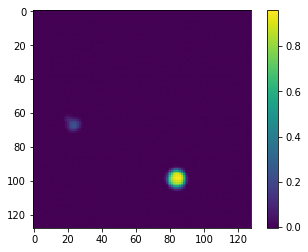

In [29]:
plt.imshow(model.predict(generator[0][0])[0][0, :, :, 0])
plt.colorbar()
plt.show()

In [10]:
model.save_weights("holo3d.h5")

In [ ]:
video = 

zero-size array to reduction operation minimum which has no identity


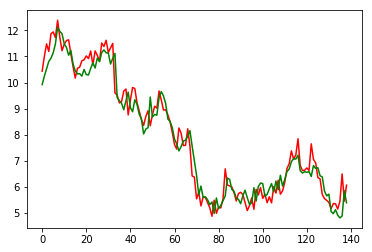

In [15]:
import skimage
trace = traces[0, 94]
trace = trace[0][0][1]

x = trace[:,1] / 0.115 / 3
y = trace[:,2] / 0.115 / 3
z = trace[:,3] 

predicted_z = []
frames = []
for i in range(int(trace[0,0]) - 202, int(trace[0,0]) - 203 + trace.shape[0], 1):
    try:
        frame = vout[::3, ::3, i:i+1]
        frame -= np.min(frame)
        frame /= np.max(frame)

        frame = frame[int(y[i])-52:int(y[i])+52, int(x[i])-52:int(x[i])+52, :]
        frames.append(frame)
        outp = model.predict(np.array([frame])) > 0.7

        CC = skimage.measure.label(outp[0])
        props = skimage.measure.regionprops(CC)
        centroids = [prop["Centroid"] for prop in props]
        idx= np.argmin(np.sum(np.abs(np.array(centroids)[:, :2]-60), axis=1))

        predicted_z.append((centroids[idx][2] + MIN_Z / Z_SCALE) * Z_SCALE / 1e-6)
    except Exception as e:
        print(e)
        break

plt.plot(np.array(predicted_z), c="r")
plt.plot(z[:len(predicted_z)] * 1.46, c="g")
plt.show()

import scipy

scipy.io.savemat("../../figures/holography_predictions.mat", {
    "frames": np.array(frames),
    "z": np.array(z),
    "pred_z": np.array(predicted_z)
})

In [47]:
import scipy.io

video = scipy.io.loadmat(r"C:\Users\bmidt\Holography tracking\HoloCode\res\1Every1_2_movie_1.aviProcessedField2.mat")


In [48]:
mapping =  scipy.io.loadmat(r"C:\Users\bmidt\Holography tracking\HoloCode\mapping.mat")["Mapping"]
v = video["ProcessedField"][0]
import matplotlib.pyplot as plt
import numpy as np
vout = []
mapping = np.transpose(mapping)
idx = 0
for frame in v:
    im = np.zeros(mapping.shape) * 0j
    im[mapping > 0] = frame[:, 0]
    im = np.fft.ifft2(im)
    vout.append(np.abs(im[::3, ::3] + 1) ** 2)
    idx += 1
    if idx > 100:
        break
    
vout = np.array(vout)

In [50]:
import skimage

positions = []
frames = []



for i in range(100):
    frame = vout[i:i+1, -400:, -400:] * 0.7 - 0.35

    frames.append(frame)

    outp = model.predict_on_batch(np.expand_dims(frame, axis=-1)) > 0.95

    CC = skimage.measure.label(outp[0])
    props = skimage.measure.regionprops(CC)
    centroids = np.array([prop["Centroid"] for prop in props])
    centroids[:, -1] = (centroids[:, -1] + MIN_Z / Z_SCALE) * Z_SCALE / 1e-6
    positions.append(centroids)



import scipy

scipy.io.savemat("../../figures/holography_video.mat", {
    "frames": np.array(frames),
    "positions": positions
})